## Mount google drive and change directory

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

!git clone https://github.com/drumpt/NMT_practice.git/ /content/drive/My\ Drive/Colab\ Notebooks/CS495\ Individual\ Study/1회차
%cd /content/drive/My\ Drive/Colab\ Notebooks/CS495\ Individual\ Study/1회차/NMT_practice
!pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/drive/My Drive/Colab Notebooks/CS495 Individual Study/1회차' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/CS495 Individual Study/1회차/NMT_practice


## Import libraries and choose device

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import easydict
import gc
import copy

import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# from torch.autograd import Variable

from dataset.dataloader import load_data, get_loader
from dataset.field import Vocab
from utils import seq2sen

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = "cuda"
else:
    device = "cpu"
print(f"Use {device} for torch")

Use cuda for torch


## Define Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        # TODO(completed) : num_identical_layers를 이용할 수 있을까? clone을 이용하면 됨.
        self.identical_layer1 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer2 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer3 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer4 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer5 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer6 = EncoderIdenticalLayer(self.model_dim, self.h).to(device)

    def forward(self, x, src_mask):
        x = self.identical_layer1(x, src_mask)
        x = self.identical_layer2(x, src_mask)
        x = self.identical_layer3(x, src_mask)
        x = self.identical_layer4(x, src_mask)
        x = self.identical_layer5(x, src_mask)
        x = self.identical_layer6(x, src_mask)
        return x

class EncoderIdenticalLayer(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        self.w_i_Q_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_K_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_V_list = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_O = nn.Linear(in_features = self.h * (self.model_dim // self.h), out_features = self.model_dim, bias = False).to(device)
        self.layer_normalization1 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension

        self.feed_forward_network1 = nn.Linear(in_features = 512, out_features = 2048, bias = True).to(device)
        self.feed_forward_network2 = nn.Linear(in_features = 2048, out_features = 512, bias = True).to(device)
        self.layer_normalization2 = nn.LayerNorm(self.model_dim).to(device) # TODO(completed): 맞나?

        self.dropout = nn.Dropout(p = 0.1).to(device)
        self.softmax = nn.Softmax(dim = 2).to(device) # TODO(completed): 이게 맞나? 2인 것 같다.
        self.relu = nn.ReLU().to(device)

    def forward(self, x, src_mask):
        ### Sublayer 1
        # Multi-Head Attention
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list[i](x),
                self.w_i_K_list[i](x).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(src_mask == 0, -1e9)
            out_softmax = self.w_i_V_list[i](x)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2) # TODO(completed): 맞나?
        multi_head_attention_output = self.dropout(self.w_O(concatenated_x))

        # Add & Layer Normalization
        multi_head_attention_output += x
        multi_head_attention_output = self.layer_normalization1(multi_head_attention_output)

        ### Sublayer 2
        # Feed-Forward Network
        ffn_output = self.feed_forward_network1(multi_head_attention_output)
        ffn_output = self.relu(ffn_output)
        ffn_output = self.feed_forward_network2(ffn_output)
        ffn_output = self.dropout(ffn_output)

        # positionwise_output_list = [] # (0, 2, 1)
        # for position in range(multi_head_attention_output.shape[1]): # token length
        #     positionwise_input = multi_head_attention_output[:, position, :]
        #     positionwise_output = self.relu(self.feed_forward_network1(positionwise_input))
        #     positionwise_output = self.feed_forward_network2(positionwise_output)
        #     positionwise_output_list.append(positionwise_output)
        # ffn_output = self.dropout(torch.stack(positionwise_output_list, dim = 1))

        # Add & Layer Normalization
        ffn_output += multi_head_attention_output
        ffn_output = self.layer_normalization2(ffn_output)
        return ffn_output

## Define Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        self.identical_layer1 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer2 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer3 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer4 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer5 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)
        self.identical_layer6 = DecoderIdenticalLayer(self.model_dim, self.h).to(device)

    def forward(self, x, y, src_mask, tgt_mask):
        x = self.identical_layer1(x, y, src_mask, tgt_mask)
        x = self.identical_layer2(x, y, src_mask, tgt_mask)
        x = self.identical_layer3(x, y, src_mask, tgt_mask)
        x = self.identical_layer4(x, y, src_mask, tgt_mask)
        x = self.identical_layer5(x, y, src_mask, tgt_mask)
        x = self.identical_layer6(x, y, src_mask, tgt_mask)
        return x

class DecoderIdenticalLayer(nn.Module):
    def __init__(self, model_dim, h):
        super().__init__()
        self.model_dim = model_dim
        self.h = h

        self.w_i_Q_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_K_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_V_list_first = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_O_first = nn.Linear(in_features = self.h * (self.model_dim // self.h), out_features = self.model_dim, bias = False).to(device)
        self.layer_normalization1 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension

        self.w_i_Q_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_K_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_i_V_list_second = [nn.Linear(in_features = self.model_dim, out_features = self.model_dim // self.h, bias = False).to(device) for _ in range(self.h)]
        self.w_O_second = nn.Linear(in_features = self.h * (self.model_dim // self.h), out_features = self.model_dim, bias = False).to(device)
        self.layer_normalization2 = nn.LayerNorm(self.model_dim).to(device) # exclude batch dimension
        
        self.feed_forward_network1 = nn.Linear(in_features = 512, out_features = 2048, bias = True).to(device)
        self.feed_forward_network2 = nn.Linear(in_features = 2048, out_features = 512, bias = True).to(device)
        self.layer_normalization3 = nn.LayerNorm(self.model_dim).to(device)

        self.dropout = nn.Dropout(p = 0.1).to(device)
        self.softmax = nn.Softmax(dim = 2).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x, y, src_mask, tgt_mask): # TODO(completed): masking 구현.
        ### Sublayer 1
        # Masked Multi-Head Attention
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list_first[i](x),
                self.w_i_K_list_first[i](x).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(tgt_mask == 0, -1e9)
            out_softmax = self.w_i_V_list_first[i](x)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2)
        multi_head_attention_output_first = self.dropout(self.w_O_first(concatenated_x))

        # Add & Layer Normalization
        multi_head_attention_output_first += x
        multi_head_attention_output_first = self.layer_normalization1(multi_head_attention_output_first)

        ## Sublayer 2
        # Multi-Head Attention
        """
        queries : come from previous decoder layer
        keys, values : come from the output of the encoder
        """
        splitted_x_list = []
        for i in range(self.h):
            in_softmax = torch.matmul(
                self.w_i_Q_list_second[i](multi_head_attention_output_first),
                self.w_i_K_list_second[i](y).transpose(1, 2)
            ) / math.sqrt(self.model_dim // self.h)
            in_softmax = in_softmax.masked_fill(src_mask == 0, -1e9)
            out_softmax = self.w_i_V_list_second[i](y)
            splitted_x = torch.matmul(self.softmax(in_softmax), out_softmax)
            splitted_x_list.append(splitted_x)
        concatenated_x = torch.cat(splitted_x_list, dim = 2)
        multi_head_attention_output_second = self.dropout(self.w_O_second(concatenated_x))

        # Masked Multi-Head Attention
        multi_head_attention_output_second += multi_head_attention_output_first
        multi_head_attention_output_second = self.layer_normalization2(multi_head_attention_output_second)

        ### Sublayer 3
        # Feed-Forward Network
        ffn_output = self.feed_forward_network1(multi_head_attention_output_second)
        ffn_output = self.relu(ffn_output)
        ffn_output = self.feed_forward_network2(ffn_output)
        ffn_output = self.dropout(ffn_output)

        # positionwise_output_list = [] # (0, 2, 1)
        # for position in range(multi_head_attention_output_second.shape[1]): # token length
        #     positionwise_input = multi_head_attention_output_second[:, position, :]
        #     positionwise_output = self.relu(self.feed_forward_network1(positionwise_input))
        #     positionwise_output = self.feed_forward_network2(positionwise_output)
        #     positionwise_output_list.append(positionwise_output)
        # ffn_output = self.dropout(torch.stack(positionwise_output_list, dim = 1))

        # Add & Layer Normalization
        ffn_output += multi_head_attention_output_second
        ffn_output = self.layer_normalization3(ffn_output)
        return ffn_output

## Define Transformer

In [5]:
class Transformer(nn.Module):
    def __init__(self, model_dim, src_vocab_size, tgt_vocab_size, max_length):
        super().__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.max_length = max_length
        self.model_dim = model_dim
        self.h = 8
        self.positional_encoding_constants = self.get_positional_encoding_constants()

        self.input_embedding = nn.Embedding(self.src_vocab_size, self.model_dim).to(device)
        self.output_embedding = nn.Embedding(self.tgt_vocab_size, self.model_dim).to(device)
        self.embedding_dropout = nn.Dropout(p = 0.1).to(device)
        self.encoder = Encoder(self.model_dim, self.h).to(device)
        self.decoder = Decoder(self.model_dim, self.h).to(device)
        self.final_linear = nn.Linear(self.model_dim, self.tgt_vocab_size).to(device)

    def forward(self, encoder_input, decoder_input, src_mask, tgt_mask): # x : encoder_input, y : decoder_input
        encoder_input = self.embedding_dropout(self.positional_encoding(self.input_embedding(encoder_input) * math.sqrt(self.model_dim)))
        encoder_output = self.encoder(encoder_input, src_mask)
        decoder_output = self.decoder(self.embedding_dropout(self.positional_encoding(self.output_embedding(decoder_input) * math.sqrt(self.model_dim))), encoder_output, src_mask, tgt_mask)
        final_output = self.final_linear(decoder_output)
        return final_output

    def positional_encoding(self, embedded_sentence): # TODO(completed): batch 단위가 아니라 문장 단위로 전달되는지 확인. 안 됨.
        encoding_result = embedded_sentence.clone().detach()
        for batch_idx in range(encoding_result.shape[0]):
            encoding_result[batch_idx] += self.positional_encoding_constants[:encoding_result.shape[1], :]
        return encoding_result
        # for batch_idx in range(embedded_sentence.shape[0]):
        #     embedded_sentence[batch_idx] += self.positional_encoding_constants[:embedded_sentence.shape[1], :]
        # return embedded_sentence

    def get_positional_encoding_constants(self): # avoid redundant calculations
        positional_encoding_constants = []
        for pos in range(self.max_length):
            pos_constants = []
            for idx in range(self.model_dim):
                if idx % 2 == 0: # idx = 2 * i -> 2 * i = idx
                    pos_constants.append(math.sin(pos / (10000 ** (idx / self.model_dim))))
                else: # idx = 2 * i + 1 -> 2 * i = idx - 1
                    pos_constants.append(math.cos(pos / (10000 ** ((idx  - 1) / self.model_dim))))
            positional_encoding_constants.append(pos_constants)
        return torch.tensor(positional_encoding_constants).to(device)
    
    def save_model(self, output_path, epoch, loss, val_loss):
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        output_filename = os.path.join(output_path, f"weights_{epoch:03d}_{loss:.4f}_{val_loss:.4f}.pt")
        torch.save(self.state_dict(), output_filename)
        return output_filename

    def plot(self, output_path, history):
        plt.subplot(2, 1, 1)
        plt.title('Accuracy versus Epoch')
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.legend(['accuracy', 'val_accuracy'], loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(2, 1, 2)
        plt.title('Loss versus Epoch')
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.legend(['loss', 'val_loss'], loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "training_result.png"))

## Define loss function and some functions

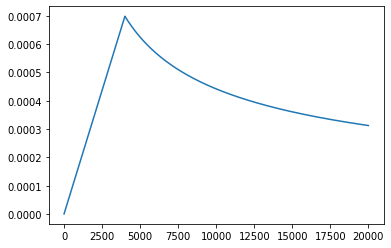

In [13]:
# class LabelSmoothingsLoss(nn.Module):
#     def __init__(self, num_classes, smoothing, dim, is_train):
#         super().__init__()
#         self.confidence = 1 - smoothing
#         self.smoothing = smoothing
#         self.num_classes = num_classes
#         self.dim = dim
#         self.is_train = is_train

#     def forward(self, pred, target, pad_start_idx_list = None):
#         pred = torch.log(pred.clone().detach().requires_grad_(True))
#         true_dist = torch.zeros_like(pred)
#         true_dist.fill_(self.smoothing / (self.num_classes - 1))
#         true_dist.scatter_(self.dim, target.data.unsqueeze(self.dim), self.confidence)
#         return torch.mean(torch.sum(-true_dist * pred, dim = self.dim))

# def get_pad_start_idx_list(tgt_batch):
#     pad_start_idx_list = []
#     for batch_idx in range(tgt_batch.shape[0]):
#         try:
#             pad_start_idx = list(tgt_batch[batch_idx]).index(2) # <pad>
#         except ValueError:
#             pad_start_idx = tgt_batch[batch_idx].shape[0]
#         pad_start_idx_list.append(pad_start_idx)
#     return pad_start_idx_list

def get_mask(batch, pad_idx, is_target = False):
    mask = (batch != pad_idx).unsqueeze(-2).to(device)
    if is_target:
        target_mask = np.triu( \
            np.ones((1, batch.size(-1), batch.size(-1))), \
            k = 1 \
        )
        target_mask = torch.from_numpy(target_mask) == 0
        mask = mask.to(device) & target_mask.to(device)
    return mask

def get_learning_rate(model_dim, step_num, warmup_steps):
    return (model_dim ** (-0.5)) * min(step_num ** (-0.5), step_num * (warmup_steps ** (-1.5)))

plt.plot(np.arange(1, 20000), [get_learning_rate(512, i, 4000) for i in range(1, 20000)])

## Use harvard model to find problem

In [14]:
# class EncoderDecoder(nn.Module):
#     """
#     A standard Encoder-Decoder architecture. Base for this and many 
#     other models.
#     """
#     def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
#         super(EncoderDecoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.src_embed = src_embed
#         self.tgt_embed = tgt_embed
#         self.generator = generator
        
#     def forward(self, src, tgt, src_mask, tgt_mask):
#         "Take in and process masked src and target sequences."
#         return self.decode(self.encode(src, src_mask), src_mask,
#                             tgt, tgt_mask)
    
#     def encode(self, src, src_mask):
#         return self.encoder(self.src_embed(src), src_mask)
    
#     def decode(self, memory, src_mask, tgt, tgt_mask):
#         return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# class Generator(nn.Module):
#     "Define standard linear + softmax generation step."
#     def __init__(self, d_model, vocab):
#         super(Generator, self).__init__()
#         self.proj = nn.Linear(d_model, vocab)

#     def forward(self, x):
#         return F.log_softmax(self.proj(x), dim=-1)

# def clones(module, N):
#     "Produce N identical layers."
#     return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# class Encoder(nn.Module):
#     "Core encoder is a stack of N layers"
#     def __init__(self, layer, N):
#         super(Encoder, self).__init__()
#         self.layers = clones(layer, N)
#         self.norm = LayerNorm(layer.size)
        
#     def forward(self, x, mask):
#         "Pass the input (and mask) through each layer in turn."
#         for layer in self.layers:
#             x = layer(x, mask)
#         return self.norm(x)

# class LayerNorm(nn.Module):
#     "Construct a layernorm module (See citation for details)."
#     def __init__(self, features, eps=1e-6):
#         super(LayerNorm, self).__init__()
#         self.a_2 = nn.Parameter(torch.ones(features))
#         self.b_2 = nn.Parameter(torch.zeros(features))
#         self.eps = eps

#     def forward(self, x):
#         mean = x.mean(-1, keepdim=True)
#         std = x.std(-1, keepdim=True)
#         return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# class SublayerConnection(nn.Module):
#     """
#     A residual connection followed by a layer norm.
#     Note for code simplicity the norm is first as opposed to last.
#     """
#     def __init__(self, size, dropout):
#         super(SublayerConnection, self).__init__()
#         self.norm = LayerNorm(size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, sublayer):
#         "Apply residual connection to any sublayer with the same size."
#         return x + self.dropout(sublayer(self.norm(x)))

# class EncoderLayer(nn.Module):
#     "Encoder is made up of self-attn and feed forward (defined below)"
#     def __init__(self, size, self_attn, feed_forward, dropout):
#         super(EncoderLayer, self).__init__()
#         self.self_attn = self_attn
#         self.feed_forward = feed_forward
#         self.sublayer = clones(SublayerConnection(size, dropout), 2)
#         self.size = size

#     def forward(self, x, mask):
#         "Follow Figure 1 (left) for connections."
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
#         return self.sublayer[1](x, self.feed_forward)

# class Decoder(nn.Module):
#     "Generic N layer decoder with masking."
#     def __init__(self, layer, N):
#         super(Decoder, self).__init__()
#         self.layers = clones(layer, N)
#         self.norm = LayerNorm(layer.size)
        
#     def forward(self, x, memory, src_mask, tgt_mask):
#         for layer in self.layers:
#             x = layer(x, memory, src_mask, tgt_mask)
#         return self.norm(x)

# class DecoderLayer(nn.Module):
#     "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
#     def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
#         super(DecoderLayer, self).__init__()
#         self.size = size
#         self.self_attn = self_attn
#         self.src_attn = src_attn
#         self.feed_forward = feed_forward
#         self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
#     def forward(self, x, memory, src_mask, tgt_mask):
#         "Follow Figure 1 (right) for connections."
#         m = memory
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
#         x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
#         return self.sublayer[2](x, self.feed_forward)

# def subsequent_mask(size):
#     "Mask out subsequent positions."
#     attn_shape = (1, size, size)
#     subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
#     return torch.from_numpy(subsequent_mask) == 0

# def attention(query, key, value, mask=None, dropout=None):
#     "Compute 'Scaled Dot Product Attention'"
#     d_k = query.size(-1)
#     scores = torch.matmul(query, key.transpose(-2, -1)) \
#              / math.sqrt(d_k)
#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, -1e9)
#     p_attn = F.softmax(scores, dim = -1)
#     if dropout is not None:
#         p_attn = dropout(p_attn)
#     return torch.matmul(p_attn, value), p_attn

# class MultiHeadedAttention(nn.Module):
#     def __init__(self, h, d_model, dropout=0.1):
#         "Take in model size and number of heads."
#         super(MultiHeadedAttention, self).__init__()
#         assert d_model % h == 0
#         # We assume d_v always equals d_k
#         self.d_k = d_model // h
#         self.h = h
#         self.linears = clones(nn.Linear(d_model, d_model), 4)
#         self.attn = None
#         self.dropout = nn.Dropout(p=dropout)
        
#     def forward(self, query, key, value, mask=None):
#         "Implements Figure 2"
#         if mask is not None:
#             # Same mask applied to all h heads.
#             mask = mask.unsqueeze(1)
#         nbatches = query.size(0)
        
#         # 1) Do all the linear projections in batch from d_model => h x d_k 
#         query, key, value = \
#             [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
#              for l, x in zip(self.linears, (query, key, value))]
        
#         # 2) Apply attention on all the projected vectors in batch. 
#         x, self.attn = attention(query, key, value, mask=mask, 
#                                  dropout=self.dropout)
        
#         # 3) "Concat" using a view and apply a final linear. 
#         x = x.transpose(1, 2).contiguous() \
#              .view(nbatches, -1, self.h * self.d_k)
#         return self.linears[-1](x)

# class PositionwiseFeedForward(nn.Module):
#     "Implements FFN equation."
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super(PositionwiseFeedForward, self).__init__()
#         self.w_1 = nn.Linear(d_model, d_ff)
#         self.w_2 = nn.Linear(d_ff, d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         return self.w_2(self.dropout(F.relu(self.w_1(x))))

# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

# class PositionalEncoding(nn.Module):
#     "Implement the PE function."
#     def __init__(self, d_model, dropout, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
        
#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) *
#                              -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)
        
#     def forward(self, x):
#         x = x + Variable(self.pe[:, :x.size(1)], 
#                          requires_grad=False)
#         return self.dropout(x)

# def make_model(src_vocab, tgt_vocab, N=6, 
#                d_model=512, d_ff=2048, h=8, dropout=0.1):
#     "Helper: Construct a model from hyperparameters."
#     c = copy.deepcopy
#     attn = MultiHeadedAttention(h, d_model)
#     ff = PositionwiseFeedForward(d_model, d_ff, dropout)
#     position = PositionalEncoding(d_model, dropout)
#     model = EncoderDecoder(
#         Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
#         Decoder(DecoderLayer(d_model, c(attn), c(attn), 
#                              c(ff), dropout), N),
#         nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
#         nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
#         Generator(d_model, tgt_vocab))
    
#     print(model)

#     # This was important from their code. 
#     # Initialize parameters with Glorot / fan_avg.
#     for p in model.parameters():
#         if p.dim() > 1:
#             nn.init.xavier_uniform_(p)
#     return model

## Define main function



In [15]:
def main(args):
    src, tgt = load_data(args.path)

    src_vocab = Vocab(init_token='<sos>', eos_token='<eos>', pad_token='<pad>', unk_token='<unk>')
    src_vocab.load(os.path.join(args.path, 'vocab.en'))
    tgt_vocab = Vocab(init_token='<sos>', eos_token='<eos>', pad_token='<pad>', unk_token='<unk>')
    tgt_vocab.load(os.path.join(args.path, 'vocab.de'))

    # TODO(completed): use these information.
    sos_idx = 0
    eos_idx = 1
    pad_idx = 2
    max_length = 50

    # TODO: use these values to construct embedding layers
    src_vocab_size = len(src_vocab)
    tgt_vocab_size = len(tgt_vocab)

    # Define training parameters
    model_dim = 512
    warmup_steps = 4000

    # Define model
    transformer = Transformer(model_dim, src_vocab_size, tgt_vocab_size, max_length)
    for param in transformer.parameters():
        if param.dim() > 1:
            nn.init.xavier_uniform_(param)
    if args.test and args.model_path: # test
        transformer.load_state_dict(torch.load(args.model_path))
        transformer.eval()

    # print(transformer.parameters())
    # for name, param in transformer.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)

    # Define optimizer
    step_num = 1
    learning_rate = get_learning_rate(model_dim, step_num, warmup_steps)
    optimizer = optim.Adam(transformer.parameters(), lr = learning_rate, betas = (0.9, 0.98), eps = 1e-8)

    # Define loss function
    ## smoothing = 0.1
    ## train_loss_function = LabelSmoothingsLoss(tgt_vocab_size, smoothing, dim = -1, is_train = True)
    ## validation_loss_function = LabelSmoothingsLoss(tgt_vocab_size, smoothing, dim = -1, is_train = False)
    train_loss_function = nn.CrossEntropyLoss(ignore_index = pad_idx).to(device)
    validation_loss_function = nn.CrossEntropyLoss(ignore_index = pad_idx).to(device)

    if not args.test:
        train_loader = get_loader(src['train'], tgt['train'], src_vocab, tgt_vocab, batch_size=args.batch_size, shuffle=True)
        valid_loader = get_loader(src['valid'], tgt['valid'], src_vocab, tgt_vocab, batch_size=args.batch_size)

        history = {
            "loss" : [],
            "val_loss" : [],
            "accuracy" : [],
            "val_accuracy" : []
        }

        for epoch in range(1, args.epochs + 1):
            print(f"Epoch {epoch}/{args.epochs}")
            total_train_size, total_validation_size = 0, 0
            epoch_train_loss, epoch_validation_loss = 0, 0
            epoch_train_correct, epoch_validation_correct = 0, 0

            # TODO(completed): train
            # for src_batch, tgt_batch in tqdm(train_loader):
            for src_batch, tgt_batch in train_loader:
                for g in optimizer.param_groups: # update learning rate first
                    g['lr'] = get_learning_rate(model_dim, step_num, warmup_steps)
                optimizer.zero_grad()

                src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                tgt_mask = get_mask(torch.tensor(tgt_batch)[:, :-1], pad_idx, is_target = True)

                prd_batch = transformer(torch.tensor(src_batch).to(device), torch.tensor(tgt_batch)[:, :-1].to(device), src_mask.to(device), tgt_mask.to(device))
                loss = train_loss_function( \
                    torch.tensor(prd_batch.transpose(-1, -2), dtype = torch.float, requires_grad = True).clone().to(device), \
                    torch.tensor(tgt_batch)[:, 1:].clone().to(device) \
                )

                loss.backward()
                optimizer.step()
                step_num += 1

                total_train_size += len(src_batch)
                epoch_train_loss += loss.data
                epoch_train_correct += int(torch.sum(torch.argmax(torch.tensor(prd_batch).data, -1) == torch.tensor(tgt_batch).data[:, 1:].to(device)))

                # print("\n\n\n\n\n\n")
                # print(total_train_size)
                # print(epoch_train_loss)
                # print(epoch_train_correct)

                gc.collect()
                torch.cuda.empty_cache()

            epoch_train_loss /= total_train_size
            epoch_train_accuracy = epoch_train_correct / total_train_size

            history["loss"].append(epoch_train_loss)    
            history["accuracy"].append(epoch_train_accuracy)

            # TODO: validation
            # for src_batch, tgt_batch in tqdm(valid_loader):
            for src_batch, tgt_batch in valid_loader:
                src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                tgt_mask = get_mask(torch.tensor(tgt_batch)[:, :-1], pad_idx, is_target = True)

                prd_batch = transformer(torch.tensor(src_batch).to(device), torch.tensor(tgt_batch)[:, :-1].to(device), src_mask.to(device), tgt_mask.to(device))
                loss = validation_loss_function( \
                    torch.tensor(prd_batch.transpose(-1, -2), dtype = torch.float, requires_grad = True).clone().to(device), \
                    torch.tensor(tgt_batch)[:, 1:].clone().to(device), \
                )

                total_validation_size += len(src_batch)
                epoch_validation_loss += loss.data
                epoch_validation_correct += int(torch.sum(torch.argmax(torch.tensor(prd_batch).data, -1) == torch.tensor(tgt_batch).data[:, 1:].to(device)))

                gc.collect()
                torch.cuda.empty_cache()

            epoch_validation_loss /= total_validation_size
            epoch_validation_accuracy = epoch_validation_correct / total_validation_size

            history["val_loss"].append(epoch_validation_loss)
            history["val_accuracy"].append(epoch_validation_accuracy)

            print(f"loss : {epoch_train_loss:.6f}, val_loss : {epoch_validation_loss:.6f}") 
            print(f"accuracy : {epoch_train_accuracy:.6f}, val_accuracy : {epoch_validation_accuracy:.6f}")

            transformer.save_model(args.output_path, epoch, epoch_train_loss, epoch_validation_loss)
        transformer.plot(args.output_path, history)

    else: # test
        test_loader = get_loader(src['test'], tgt['test'], src_vocab, tgt_vocab, batch_size=args.batch_size)

        pred = []
        # for src_batch, tgt_batch in tqdm(test_loader):
        for src_batch, tgt_batch in test_loader:
            # TODO: predict pred_batch from src_batch with your model.
            result_batch = torch.tensor([sos_idx for _ in range(len(src_batch))]).unsqueeze(-1)
            for idx in range(max_length):
                if idx == max_length - 1:
                    pred_batch = torch.full((len(src_batch), 1), eos_idx)
                else:
                    src_mask = get_mask(torch.tensor(src_batch), pad_idx, is_target = False)
                    result_mask = get_mask(torch.tensor(result_batch), pad_idx, is_target = True)

                    pred_batch = transformer(torch.tensor(src_batch).to(device), result_batch.to(device), src_mask.to(device), result_mask.to(device))[:, -1, :] # consider only last result
                    pred_batch[:, sos_idx] += -1e9 # exclude <sos>
                    pred_batch[:, pad_idx] += -1e9 # exclude <pad>
                    pred_batch = torch.argmax(pred_batch, dim = -1).unsqueeze(-1)
                result_batch = torch.cat((result_batch.to(device), pred_batch.to(device)), dim = -1)
            result_batch = result_batch[1:, :] # remove <sos> from the result

            max_length = 0
            for batch_idx in range(result_batch.shape[0]):
                max_length = max(max_length, list(result_batch[batch_idx]).index(eos_idx)) # find <eos>
            result_batch = result_batch[:max_length, :].tolist()
            pred += seq2sen(result_batch, tgt_vocab)

            gc.collect()
            torch.cuda.empty_cache()

        with open('results/pred.txt', 'w') as f:
            for line in pred:
                f.write('{}\n'.format(line))
            f.close()

        os.system('bash scripts/bleu.sh results/pred.txt multi30k/test.de.atok')

## Call main function

In [16]:
args = easydict.EasyDict({
    "path": "multi30k",
    "epochs": 100,
    "batch_size": 128,
    "test": True,
    "output_path": "resources",
    "model_path": "resources/weights_010_0.0663_0.0668.pt"
})

main(args)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Use console

In [17]:
from kora import console
console.start()

Console URL: https://teleconsole.com/s/2112f2cb151b6384601bec8d8782243776124afa
